In [1]:
import torch

In [2]:
ITERATIONS = 50_000
EPS = 1e-3
X_0 = 1.5

In [3]:
class GradDescGeneral:
    def __init__(
            self,
            fn,
            derivative,
    ):
        self.fn = fn
        self.derivative = derivative

    def __call__(
            self,
            starting_point,
            iterations: int,
            linear_method,
            eps: float = EPS ** 2
    ):
        path = []
        cur_x = starting_point
        iteration = 0
        for iteration in range(iterations):
            path.append((cur_x, self.fn(cur_x)))

            gradient = self.derivative(cur_x)
            
            lr = linear_method(cur_x, gradient)

            new_x = cur_x - lr * gradient

            if torch.all(torch.abs(cur_x - new_x) < eps):
                break

            cur_x = new_x

        return cur_x, path, iteration + 1

In [4]:
class DefaultMethod:
    def __init__(self, lr: float) -> None:
        self.lr = lr
        
    def __call__(self, cur_x, gradient):
        return self.lr

In [5]:
cuda = torch.device('cuda') 

In [6]:
def matrix_form(n, k):
    diag, indicies = torch.sort((1 - k) * torch.rand(n) + k, descending=True)
    diag[0], diag[-1] = k, 1
    E = torch.diag(diag)
    E = E.to(device=cuda)
    Q, _ = torch.linalg.qr(torch.rand(n, n, device=cuda))
    return Q @ E @ Q.T

def generate_func(n, k):
    M = matrix_form(n, k)

    def f(args):
        args = args.to(device=cuda)
        return args.T @ M @ args

    def grad(args):
        args = args.to(device=cuda)
        return (M + M.T) @ args

    return f, grad


In [7]:
cond_numbers = [2 ** i for i in range(10)] + [1000]
dims = [2 ** i for i in range(10)] + [1000]

In [8]:
ITERATIONS = 50_000

data = []

for dim in dims:
    print(f"N_dim = {dim}: ")
    for cond_number in cond_numbers:
        fn, derivative = generate_func(dim, cond_number)
        # print(f"\tConditional number = {cond_number}")
        optimizer = GradDescGeneral(fn, derivative)
        x_minimum, trace, iterations = optimizer(
            starting_point=torch.rand(dim).to(cuda),
            iterations=ITERATIONS,
            linear_method=DefaultMethod(EPS)
        )
        
        data.append([dim, cond_number, iterations])

N_dim = 1: 


/tmp/ipykernel_22574/616227850.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  return args.T @ M @ args


N_dim = 2: 
N_dim = 4: 
N_dim = 8: 
N_dim = 16: 
N_dim = 32: 
N_dim = 64: 
N_dim = 128: 
N_dim = 256: 
N_dim = 512: 
N_dim = 1000: 


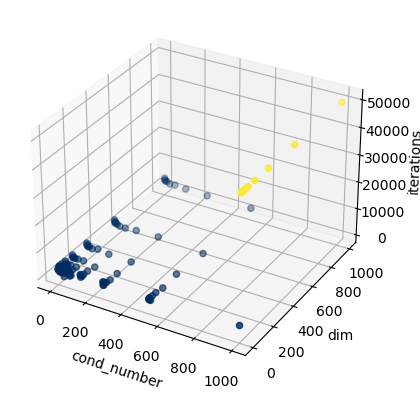

In [15]:
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')

z = [x[2] for x in data]
x = [x[1] for x in data]
y = [x[0] for x in data]

ax.set_ylabel('dim')
ax.set_xlabel('cond_number')
ax.set_zlabel('iterations')

ax.scatter3D(x, y, z, c=z, cmap='cividis')

plt.show()